In [ ]:
import networkx as nx
import numpy as np
import random
import pandas as pd
!pip install rdkit
from rdkit import Chem
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense , Dropout, BatchNormalization
from rdkit.Chem import Draw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 41.5 MB/s eta 0:00:00


In [ ]:
df=pd.read_csv("/content/HIV.csv")

ploting samples of HIV Active molecules

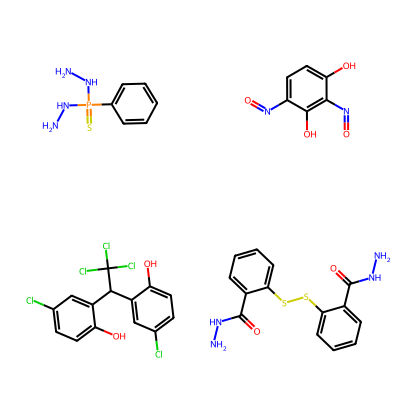

In [ ]:
mols= [Chem.MolFromSmiles(df[df['HIV_active']==1]['smiles'].iloc[i]) for i in range(1,5)]
img=Draw.MolsToGridImage(mols, molsPerRow=2,subImgSize=(200,200))
img

ploting HIV Inactive molecules

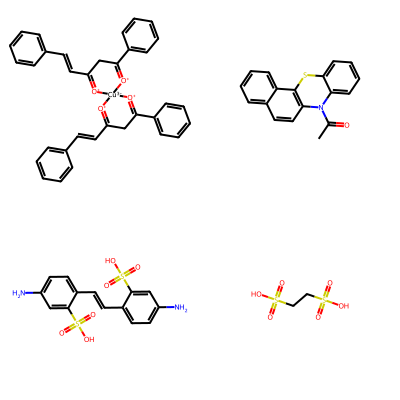

In [ ]:
mols= [Chem.MolFromSmiles(df[df['HIV_active']==0]['smiles'].iloc[i]) for i in range(1,5)]
img=Draw.MolsToGridImage(mols, molsPerRow=2,subImgSize=(200,200))
img

doing an exploratory analysis , as the molcules are of different size , we have to find a proper maximum size for our graphs

In [ ]:
#this function finds the number of atoms in the each molcule
def numofatoms (x):
      return len(Chem.MolFromSmiles(x).GetAtoms())

In [ ]:
df['num_atoms']=df['smiles'].apply(numofatoms)

[23:54:37] WARNING: not removing hydrogen atom without neighbors
[23:54:37] WARNING: not removing hydrogen atom without neighbors


In [ ]:
df.head()

,smiles,activity,HIV_active,num_atoms
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,19
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,39
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,21
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,24
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,10


In [ ]:
df.groupby('HIV_active')['num_atoms'].describe()

,count,mean,std,min,25%,50%,75%,max
HIV_active,,,,,,,,
0,40426.0,25.212833,11.607170,2.0,18.0,23.0,29.0,214.0
1,1487.0,34.104909,20.252704,6.0,21.0,27.0,43.0,222.0


i choose 44 as the maximum number of atoms , and choose atoms with max of this size

In [ ]:
df1=df[df['num_atoms']<45]

HIV active samples with the maximum size 45

In [ ]:
df2=df1[df1['HIV_active']==1]


HIV inactive samples with the maximum size 45

In [ ]:

df3=df1[df1['HIV_active']==0]

features extractor function , this function :
1: creates networkx graph objects from smiles text with help of rdkit methods , extracts  weigthed Adjcanacy matrix for the molcule, makes suitable for graph massage passing , padds and returns it .
2 : extracts node degrees from the graph , padds and return it .
(this will be used in node features augmentation with sturctural features to help the GNN models have better understading of molcular structures)
3: creates mask used for masking padding outputs of GNN model .


In [ ]:
def atom_features(m):
  molcule=Chem.MolFromSmiles(m)

  G=nx.Graph()
  Atoms=[ Atom.GetAtomicNum() for Atom in molcule.GetAtoms()]
  len_A=len(Atoms)

  Atoms=np.pad(np.array(Atoms).reshape(1,len(Atoms)), ((0, 0), (0,44-len(Atoms) ))).reshape(-1)

  for bond in molcule.GetBonds():
    G.add_edge(bond.GetBeginAtomIdx(),bond.GetEndAtomIdx(),weight=bond.GetBondTypeAsDouble())

  adj_matrix=nx.adjacency_matrix(G).todense()
  degrees=np.array(list(dict(G.degree()).values()))
  pad_rows = 44 - adj_matrix.shape[0]
  pad_cols = 44 - adj_matrix.shape[1]

  mask =np.eye(adj_matrix.shape[0])
  mask=np.pad(mask, ((0, pad_rows), (0, pad_cols)), mode='constant')
  degrees=np.pad(degrees, (0, pad_cols), mode='constant')
  degrees=degrees.astype(np.float32)/7

  btws=nx.betweenness_centrality(G)
  btws=np.pad(np.array([ btws[list(btws.keys())[i]] for i in range(len(btws))]), (0, 44-len(btws)), mode='constant')
  adj_matrix= np.pad(adj_matrix, ((0, pad_rows), (0, pad_cols)), mode='constant')
  adj_matrix=adj_matrix+np.eye(44)

  adj_matrix=adj_matrix/adj_matrix.sum(axis=1)

  degree_m=np.diag(degrees)
  #x=np.argpartition(btws,-10)[-10:]
  #x2=np.zeros_like(btws)
  #x2[x]=1
  #x2=np.diag(x2)
  return  Atoms , adj_matrix, mask ,btws,degrees , degree_m
  #x2





In [ ]:
train_df2,test_df2,train_labels_df2, test_labels_df2=train_test_split(df2['smiles'],df2['HIV_active'],test_size=0.1,shuffle=True , random_state=42)
train_df3,test_df3,train_labels_df3, test_labels_df3=train_test_split(df3['smiles'],df3['HIV_active'],test_size=0.1,shuffle=True , random_state=42)

creating a custom graph convolutional layer class , with inherting from tensorflow Layer class (custom tensorflow layer)

In [ ]:

class GCN_layer(tf.keras.layers.Layer):
    def __init__(self,output_dim):
        self.output_dim = output_dim

        super(GCN_layer, self).__init__()

    def build(self, input_shapes):
        input_shape,adj_shape=input_shapes
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1], self.output_dim),
                                      initializer='glorot_uniform',
                                      trainable=True,
                                      regularizer=tf.keras.regularizers.l2(0.005))

    def call(self, inputs):
        input, adj=inputs
        x1=tf.matmul(input, self.kernel)
        x2=tf.matmul(tf.cast(adj, tf.float32),x1)
        return tf.keras.activations.relu(x2)



implementation of Multi head attention for graphs network class based on the paper ,
 with subclassing tensorflow Layer class (tensorflow custom layer )

In [ ]:
#########multi head
class GAT_layer(tf.keras.layers.Layer):
    def __init__(self,Att_output_dim,num_heads):
        super(GAT_layer, self).__init__()
        self.Att_output_dim=Att_output_dim
        self.num_heads=num_heads
        self.leaky_relu=tf.keras.layers.LeakyReLU(alpha=0.1)
        self.elu=tf.keras.layers.ELU()

    def build(self, input_shapes):
        input_features_shape, adj_shape=input_shapes
        self.GConv = self.add_weight(name='GConv',
                                      shape=(input_features_shape[-1],self.Att_output_dim ),
                                      initializer='glorot_uniform',
                                      trainable=True,
                                      regularizer=tf.keras.regularizers.l2(0.005))

        self.Att=self.add_weight(name='Att',
                                      shape=(2*self.Att_output_dim,self.num_heads ),
                                      initializer='glorot_uniform',
                                      trainable=True,
                                      regularizer=tf.keras.regularizers.l2(0.005))

    def call(self, inputs):
        input_features,adjs=inputs
        features=tf.matmul(input_features,self.GConv)
        batch_size= features.shape[0]
        N=features.shape[1]
        embed_len=features.shape[2]
        h1 = tf.tile(tf.expand_dims(features, axis=2), [1,1,N,1])
        h1=tf.reshape(h1,[batch_size,N*N, embed_len])

        h2 = tf.tile(tf.expand_dims(features, axis=1), [1,N, 1, 1])
        h2=tf.reshape(h2, [batch_size, N*N,embed_len])



        h= tf.concat([h1,h2], axis=2)

        h= tf.matmul(h, self.Att)
        h=tf.transpose(h,[0,2,1])
        h=tf.reshape(h, [batch_size,self.num_heads,N,N])

        adjs=tf.tile(tf.expand_dims(adjs,axis=1),[1,self.num_heads,1,1])
        Att_adjs=tf.multiply(adjs, h)
        Att_adjs=self.leaky_relu(Att_adjs)
        #Applying masked softmax
        Att_adjs=tf.math.exp(Att_adjs)
        Att_adjs=tf.multiply(adjs,Att_adjs)
        Att_adjs_sum=tf.reduce_sum(Att_adjs, axis=-1,keepdims=True)
        Att_adjs=tf.divide(Att_adjs, Att_adjs_sum)

        features_tiled=tf.tile(tf.expand_dims(features,axis=1),[1,self.num_heads,1,1])
        outputs=tf.matmul(Att_adjs,features_tiled)
        # sum aggreageting multi head outputs
        outputs=tf.reduce_sum(outputs, axis=1)
        return self.elu(outputs)




creating custom tensorflow model . with inherting from tensorflow Model class , to have message passing from all over the graphs , i choose three layer to cover most parts of the graphs

embedding layer is key part of the model functioning . very similar to embedding words in text classification , here i embedd each atom type

GNNs are powerfull learning models , how ever they have weaknesses in understanding some of structural features , we can help GNNs in learning the  structure of the graphs by extracting and adding some of structural features to the nodes embeddings .

as we are dealing with molcules (graphs ) of different size , very similar to dealing with text data , we need to padd our inputs , and mask their related output.

in the call method of our custom model , we specify the training paramter ,
this technique is very usefull if we want the model to have some different charachterisitc  while training and test .

at end ,our goal is to find a graph embeddings from their node embeddings , to aggregate this information i used sum aggregation , this can be usefull as in sum aggregation in graph classification , the number of nodes of the each graph , can effect on the overall embeddings .

In [ ]:

class GAT_model(tf.keras.Model):
  def __init__(self):
        super(GAT_model, self).__init__()

        self.GCN_layer1=GCN_layer(60)
        #self.GCN_layer2=GCN_layer(30)
       # self.GAT_layer0=GAT_layer(Att_output_dim=40,num_heads=10)

        self.GAT_layer1=GAT_layer(Att_output_dim=50,num_heads=10)

        self.GAT_layer2=GAT_layer(Att_output_dim=40,num_heads=10)



        self.Dense1=tf.keras.layers.Dense(40, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.005))
       # self.Dense2=tf.keras.layers.Dense(20, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.005))

        self.Dense3=tf.keras.layers.Dense(1,activation='sigmoid')
        self.batch_norm0=BatchNormalization()
        self.batch_norm1=BatchNormalization()
        self.batch_norm2=BatchNormalization()
        self.batch_norm3=BatchNormalization()

        self.dropout0=Dropout(0.05)
        self.dropout1=Dropout(0.05)
        self.dropout2=Dropout(0.05)

        self.Embedding_layer=tf.keras.layers.Embedding(input_dim=93,  output_dim=1000, mask_zero=True)
  def call(self, inputs, training=True):
    if training :
      Atoms,adj_1, mask,btws, degrees , degree_m= inputs
      #print(mask)
      batch_size=tf.shape(Atoms)[0]

      embeddings=self.Embedding_layer(Atoms)
      btws=tf.expand_dims(btws,axis=2)
      embeddings=tf.concat([embeddings,btws],axis=2)
      degrees=tf.expand_dims(degrees,axis=2)
      embeddings=tf.concat([embeddings,degrees],axis=2)


      output1=self.GCN_layer1([embeddings,adj_1])
      output1=self.batch_norm0(output1)
      output1=self.dropout0(output1)

      output1=self.GAT_layer1([tf.matmul(mask,output1),adj_1])
      #print(output1)
      output1=output1/tf.reduce_sum(mask,axis=[1,2], keepdims=True)
      output1=self.batch_norm1(output1)
      output1=self.dropout1(output1)



      output1=self.GAT_layer2([tf.matmul(mask,output1),adj_1])
      output1=output1/tf.reduce_sum(mask,axis=[1,2], keepdims=True)
      output1=self.batch_norm2(output1)
      output1=self.dropout2(output1)


      #output2_m=tf.reduce_sum( tf.matmul(mask,output1),axis=1)
    ##weigthed sum over the embeddings of the nodes in the graph based on their degree
      output2_m=tf.reduce_sum( tf.matmul(degree_m,output1),axis=1)

      output2_m=self.batch_norm3(output2_m)


      output2_m=self.Dense1(output2_m)
      #output2_m=self.Dense2(output2_m)
      output4=self.Dense3(output2_m)
      output4=tf.squeeze(output4)

      return output4
    else :
      Atoms,adj_1, mask,btws, degrees, btws_m = inputs
      #print(mask)
      batch_size=tf.shape(Atoms)[0]

      embeddings=self.Embedding_layer(Atoms)
      btws=tf.expand_dims(btws,axis=2)
      embeddings=tf.concat([embeddings,btws],axis=2)
      degrees=tf.expand_dims(degrees,axis=2)
      embeddings=tf.concat([embeddings,degrees],axis=2)

      output1=self.GCN_layer1([embeddings,adj_1])
      output1=self.batch_norm0(output1)

      output1=self.GAT_layer1([tf.matmul(mask,output1),adj_1])
      #print(output1)
      output1=output1/tf.reduce_sum(mask,axis=[1,2], keepdims=True)
      output1=self.batch_norm1(output1)




      output1=self.GAT_layer2([tf.matmul(mask,output1),adj_1])
      output1=output1/tf.reduce_sum(mask,axis=[1,2], keepdims=True)
      output1=self.batch_norm2(output1)


      #output2_m=tf.reduce_sum( tf.matmul(mask,output1),axis=1)

      ##weigthed sum over the embeddings of the nodes in the graph based on their degree
      output2_m=tf.reduce_sum( tf.matmul(degree_m,output1),axis=1)
      output2_m=self.batch_norm3(output2_m)


      output2_m=self.Dense1(output2_m)
      #output2_m=self.Dense2(output2_m)
      output4=self.Dense3(output2_m)
      output4=tf.squeeze(output4)

      return output4


deifining loss and creating model object

In [ ]:
loss_f=tf.keras.losses.BinaryCrossentropy()
model = GAT_model()


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

custom training loop instead of using model.fit for better control , as the the dataset is highly imbalanced , i did oversampling to overcome this issue , then training the model with a for loop and tf.gradients().

this custom training loop consists of a custom data generator too , which can be defined as python generator too .

In [ ]:
batch_size = 30
np.random.seed(42)
for t in range(1):
  train_df2_s=pd.concat([train_df2]*(int(1.02*len(train_df3)//len(train_df2))),ignore_index=True)
  train_data=pd.concat([train_df2_s,train_df3])
  p = np.random.permutation(len(train_data))
  train_data=train_data.iloc[p]

  train_labels_df2_s=pd.concat([train_labels_df2]*(int(1.02*len(train_labels_df3)//len(train_labels_df2))),ignore_index=True)
  train_labels=pd.concat([train_labels_df2_s,train_labels_df3])
  train_labels=train_labels.iloc[p]
# Training loop
  num_epochs=1
  for epoch in range(num_epochs):

    num_batches = len(train_data) // batch_size

    for i in range(num_batches):
        start_index = i * batch_size
        end_index = start_index + batch_size
        x=train_data.iloc[start_index: end_index].apply(atom_features)
        batch_atoms = np.array([x.iloc[j][0] for j in range(batch_size)])
        batch_padded_adj_matrix = np.array([x.iloc[j][1] for j in range(batch_size)])
        batch_mask = np.array([x.iloc[j][2] for j in range(batch_size)])
        batch_btws = np.array([x.iloc[j][3] for j in range(batch_size)])
        batch_degrees = np.array([x.iloc[j][4] for j in range(batch_size)])
        batch_degree_m= np.array([x.iloc[j][5] for j in range(batch_size)])

        batch_train_labels = tf.cast(train_labels.iloc[start_index:end_index], tf.float32)

        with tf.GradientTape() as tape:
            logits = model([batch_atoms, batch_padded_adj_matrix, batch_mask,batch_btws,batch_degrees, batch_degree_m ], training=True)
            loss = loss_f(logits, batch_train_labels)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))



[00:40:54] WARNING: not removing hydrogen atom without neighbors
[00:40:54] WARNING: not removing hydrogen atom without neighbors


In [ ]:
# model evaluation on test data of two classes
test_data=test_df2
test_labels=test_labels_df2

predictionsA = []
for i in range(int(len(test_data))):
    batch_atoms = np.expand_dims(np.array(atom_features(test_data.iloc[i])[0]),axis=0)
    batch_padded_adj_matrix = np.expand_dims(np.array(atom_features(test_data.iloc[i])[1]),axis=0)
    batch_mask = np.expand_dims(np.array(atom_features(test_data.iloc[i])[2] ),axis=0)
    batch_btws = np.expand_dims(np.array(atom_features(test_data.iloc[i])[3] ),axis=0)
    batch_degrees = np.expand_dims(np.array(atom_features(test_data.iloc[i])[4] ),axis=0)
    batch_degree_m = np.expand_dims(np.array(atom_features(test_data.iloc[i])[5] ),axis=0)


    batch_predictions = model([batch_atoms, batch_padded_adj_matrix, batch_mask,batch_btws, batch_degrees,batch_degree_m], training=False)
    predictionsA.append(batch_predictions)

predictions2 = np.array(predictionsA)
binary_predictions2 = np.where(predictions2 < 0.5, 0, 1)
recall2 = np.mean(binary_predictions2 == test_labels.values.reshape(-1, 1))
print(accuracy2)

test_data=test_df3
test_labels=test_labels_df3
predictions = []
for i in range(int(len(test_data))):
    batch_atoms = np.expand_dims(np.array(atom_features(test_data.iloc[i])[0]),axis=0)
    batch_padded_adj_matrix = np.expand_dims(np.array(atom_features(test_data.iloc[i])[1]),axis=0)
    batch_mask = np.expand_dims(np.array(atom_features(test_data.iloc[i])[2] ),axis=0)
    batch_btws = np.expand_dims(np.array(atom_features(test_data.iloc[i])[3] ),axis=0)

    batch_degrees = np.expand_dims(np.array(atom_features(test_data.iloc[i])[4] ),axis=0)
    batch_degree_m = np.expand_dims(np.array(atom_features(test_data.iloc[i])[5] ),axis=0)


    batch_predictions = model([batch_atoms, batch_padded_adj_matrix, batch_mask,batch_btws, batch_degrees,batch_degree_m], training=False)
    predictions.append(batch_predictions)

predictions3 = np.array(predictions)
binary_predictions3 = np.where(predictions3 < 0.5, 0, 1)
recall3=np.mean(binary_predictions3 == test_labels.values.reshape(-1, 1))
print(recall3)

0.7280701754385965
0.6906062971636742


graph representation learning with dummy node :

In [ ]:
# custom generator :
def atom_features(m):
  molcule=Chem.MolFromSmiles(m)

  G=nx.Graph()
  G.add_node(94)
  Atoms=[ Atom.GetAtomicNum() for Atom in molcule.GetAtoms()]
  len_A=len(Atoms)
  for i in range(len_A):
    G.add_edge(94,i,weight=1)
  Atoms=np.concatenate([np.array([94]),Atoms])
  Atoms=np.pad(np.array(Atoms).reshape(1,len(Atoms)), ((0, 0), (0,45-len(Atoms) ))).reshape(-1)

  for bond in molcule.GetBonds():
    #G.add_edge(bond.GetBeginAtomIdx(),bond.GetEndAtomIdx())
    G.add_edge(bond.GetBeginAtomIdx(),bond.GetEndAtomIdx(),weight=bond.GetBondTypeAsDouble())

  adj_matrix=nx.adjacency_matrix(G).todense()
  degrees=np.array(list(dict(G.degree()).values()))
  pad_rows = 45 - adj_matrix.shape[0]
  pad_cols = 45 - adj_matrix.shape[1]

  mask =np.eye(adj_matrix.shape[0])
  mask=np.pad(mask, ((0, pad_rows), (0, pad_cols)), mode='constant')
  degrees=np.pad(degrees, (0, pad_cols), mode='constant')
  degrees=degrees.astype(np.float32)

  btws=nx.betweenness_centrality(G)
  btws=np.pad(np.array([ btws[list(btws.keys())[i]] for i in range(len(btws))]), (0, 45-len(btws)), mode='constant')
# Pad the original matrix with zeros
  adj_matrix= np.pad(adj_matrix, ((0, pad_rows), (0, pad_cols)), mode='constant')
  adj_matrix=adj_matrix+np.eye(45)
 # print(adj_matrix.sum(axis=0))
  #print(adj_matrix)
  adj_matrix=adj_matrix
  #adj_matrix.sum(axis=1)



  return  Atoms , adj_matrix, mask, btws,degrees





In [ ]:

class GCN_model(tf.keras.Model):
  def __init__(self):
        super(GCN_model, self).__init__()

        self.GCN_layer1=GCN_layer(10)
        self.GAT_layer2=GAT_layer(Att_output_dim=10,num_heads=5)
     #   self.Dense1=tf.keras.layers.Dense(5, activation='relu')
        self.Dense3=tf.keras.layers.Dense(1,activation='sigmoid')
        self.batch_norm1=BatchNormalization()
        self.batch_norm2=BatchNormalization()
        self.batch_norm3=BatchNormalization()

        self.dropout1=Dropout(0.1)
        self.dropout2=Dropout(0.1)

        self.Embedding_layer=tf.keras.layers.Embedding(input_dim=93,  output_dim=40, mask_zero=True)
  def call(self, inputs, training=True):
    if training :
      Atoms,adj_1, mask, btws, degrees = inputs
      #print(mask)
      batch_size=tf.shape(Atoms)[0]
      embeddings=self.Embedding_layer(Atoms)

      embeddings=tf.matmul(mask,embeddings)
      output1=self.GCN_layer1([embeddings,adj_1])
      output1=self.batch_norm1(output1)
      output1=self.dropout1(output1)

      output1=self.GAT_layer2([tf.matmul(mask,output1),adj_1])

      output1=self.batch_norm2(output1)
      output1=self.dropout2(output1)
      output2_m=tf.reduce_sum( tf.matmul(mask,output1),axis=1)
      output2_m=self.batch_norm3(output2_m)

      output4=self.Dense3(output2_m)
      output4=tf.squeeze(output4)
      return output4
